In [7]:
import pandas as pd
import numpy as np
from typing import Sequence
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Load Data

In [111]:
def rename_country(df: pd.DataFrame):
    df['country'] = df['country'].replace('US','United States of America')
    df['country'] = df['country'].replace('United States','United States of America')
    df['country'] = df['country'].replace('Korea, South','South Korea')
    df['country'] = df['country'].replace('Congo (Brazzaville)','Congo')
    df['country'] = df['country'].replace('Congo (Kinshasa)','Congo')
    df['country'] = df['country'].replace('Taiwan*','Taiwan')
    df['country'] = df['country'].replace('Dominican Republic','Dominican Rep.')
    df['country'] = df['country'].replace("Cote d'Ivoire","Côte d'Ivoire")
    df['country'] = df['country'].replace('Central African Republic',"Central African Rep.")
    df['country'] = df['country'].replace('Equatorial Guinea',"Eq. Guinea")
    df['country'] = df['country'].replace('Eswatini',"eSwatini")
    df['country'] = df['country'].replace('Solomon Islands','Solomon Is.')
    df['country'] = df['country'].replace('Bosnia and Herzegovina',"Bosnia and Herz.")
    df['country'] = df['country'].replace('South Sudan','S. Sudan')

In [112]:
location = pd.read_csv('data/location.csv').rename(columns=({'Country_Region': 'country','Lat': 'latitude','Long_': 'longitude','Province_State': 'province'}))
train = pd.read_csv('data/cases_train.csv')

rename_country(train)
rename_country(location)

continent_map = pd.read_csv('data/countries_continent.csv')
populations_country = pd.read_csv('data/population_countries.csv')
populations_continents = pd.read_csv('data/population_continent.csv')

print('\ndatasets imported')
print('location: {0} rows'.format(len(location)))
print('train: {0} rows'.format(len(train)))

agg = pd.merge(pd.concat([location,train]), continent_map, how='left',on=['country'])


datasets imported
location: 4004 rows
train: 205846 rows


# Data Visualization

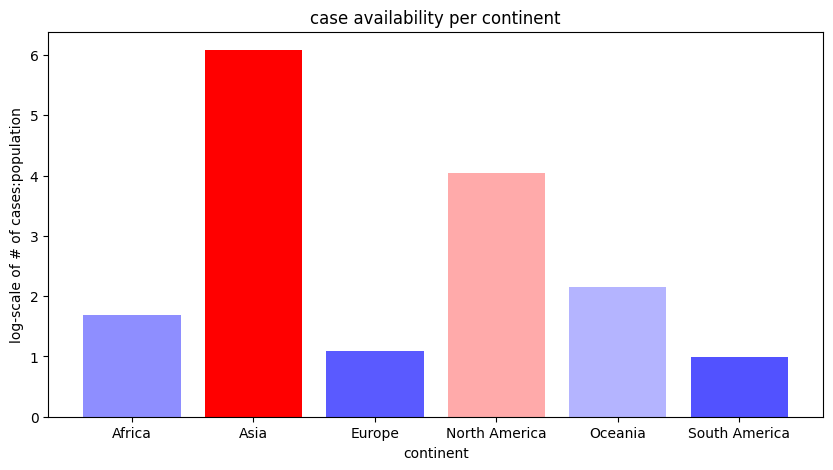

In [120]:
agg_counts = pd.DataFrame(agg.groupby(['continent']).size())
agg_counts.reset_index(inplace=True)
agg_counts.columns = ['continent', 'n_cases']

wpop_continent= pd.merge(agg_counts, populations_continents, on='continent')
wpop_continent['availability'] = np.log(wpop_continent['n_cases']*10000000/wpop_continent['population'])

cmap = plt.get_cmap('bwr')
plt.figure(figsize=(10,5))
plt.bar(wpop_continent['continent'],wpop_continent['availability'], color=cmap(wpop_continent['availability']/max(wpop_continent['availability'])))
plt.xlabel('continent')
plt.ylabel('log-scale of # of cases:population')
plt.title('case availability per continent')
plt.savefig('plots/bar_availability.png')
plt.show()

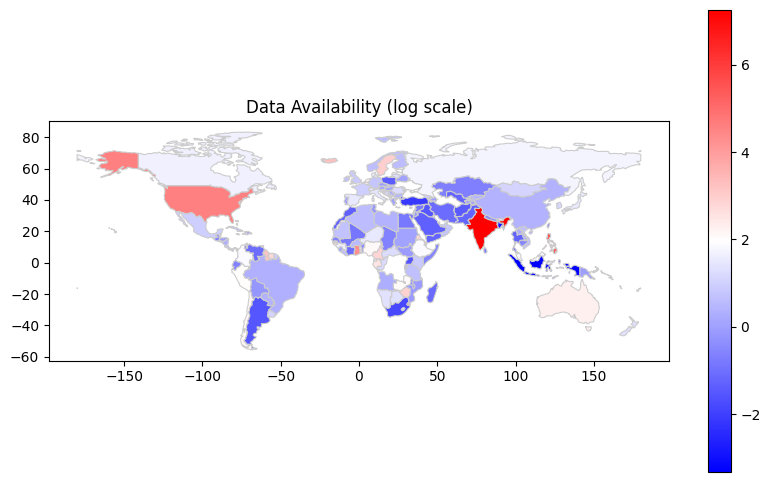

In [121]:
import geopandas as gpd
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

agg_counts = pd.DataFrame(agg.groupby(['country']).size())
agg_counts.reset_index(inplace=True)
agg_counts.columns = ['country', 'n_cases']

wpop_country = pd.merge(agg_counts, populations_country, on='country')
wpop_country['availability'] = np.log(wpop_country['n_cases']*10000000/wpop_country['population'])
fig, ax = plt.subplots(figsize=(10, 6))
world_wdata = world.merge(wpop_country, how='left', left_on='NAME', right_on='country')
world_wdata.plot(column='availability', cmap='bwr', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Data Availability (log scale)')
plt.savefig('plots/map_availability.png')

# Data Preprocessing

In [133]:
to_drop = []
for col in location.columns:
    percentNaN = location[col].isna().sum()/len(location)
    if percentNaN > 0.5:
        to_drop.append(col)

print('columns with >50% NaN (location):\n',to_drop)

to_drop = []
for col in train.columns:
    percentNaN = train[col].isna().sum()/len(train)
    if percentNaN > 0.5:
        to_drop.append(col)
print('columns with >50% NaN (train):\n',to_drop)

outcome_map = {
    'dead': 'dead',
    'death': 'dead',
    'deceased': 'dead',
    'died': 'dead',
    'recovered': 'alive',
    'alive': 'alive',
    'discharge': 'alive',
    'discharged': 'alive',
    'stable condition': 'alive',
    'stable': 'alive',
    'treating': 'alive',
    'released from quarantine': 'alive',
    'receiving treatment': 'treating',
    'under treatment': 'treating',
    'hospitalized': 'treating',
    'critical condition': 'treating',
    'recovering at home 03.03.2020': 'alive',
    'discharged from hospital': 'alive',
    'nan': 'NaN'
}
train['outcome'] = train['outcome'].apply(lambda x: outcome_map[x.lower()] if type(x) == str else np.NaN)
print('\n',train.columns)
print('\n',location.columns)

columns with >50% NaN (location):
 ['Recovered', 'Active']
columns with >50% NaN (train):
 ['age', 'sex', 'additional_information', 'outcome_group']

 Index(['age', 'sex', 'province', 'country', 'latitude', 'longitude',
       'date_confirmation', 'additional_information', 'source',
       'chronic_disease_binary', 'outcome', 'outcome_group'],
      dtype='object')

 Index(['province', 'country', 'Last_Update', 'latitude', 'longitude',
       'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key',
       'Incident_Rate', 'Case_Fatality_Ratio'],
      dtype='object')


In [134]:
join = pd.merge(train, location, how='inner', on=['country','province'])
join['Expected_Mortality_Rate'] = np.NaN
join

,age,sex,province,country,latitude_x,longitude_x,date_confirmation,additional_information,source,chronic_disease_binary,...,latitude_y,longitude_y,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Expected_Mortality_Rate
0,NaN,NaN,Maharashtra,India,19.20000,72.96667,23.05.2020,NaN,NaN,False,...,19.449759,76.108221,2812980,54649,2400727.0,357604.0,"Maharashtra, India",2284.297169,1.942744,NaN
1,NaN,NaN,Maharashtra,India,18.94017,72.83483,18.05.2020,NaN,https://t.me/indiacovid/5075,False,...,19.449759,76.108221,2812980,54649,2400727.0,357604.0,"Maharashtra, India",2284.297169,1.942744,NaN
2,NaN,NaN,Maharashtra,India,19.20000,72.96667,28.05.2020,NaN,https://phdmah.maps.arcgis.com/apps/opsdashboa...,False,...,19.449759,76.108221,2812980,54649,2400727.0,357604.0,"Maharashtra, India",2284.297169,1.942744,NaN
3,NaN,NaN,West Bengal,India,22.80862,88.79242,09.05.2020,NaN,https://www.wbhealth.gov.in/uploaded_files/cor...,False,...,23.814082,87.979803,586915,10329,570811.0,5775.0,"West Bengal, India",589.217053,1.759880,NaN
4,NaN,NaN,Maharashtra,India,18.94017,72.83483,17.05.2020,NaN,NaN,False,...,19.449759,76.108221,2812980,54649,2400727.0,357604.0,"Maharashtra, India",2284.297169,1.942744,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200622,NaN,NaN,Maharashtra,India,16.70446,74.24137,21.05.2020,NaN,NaN,False,...,19.449759,76.108221,2812980,54649,2400727.0,357604.0,"Maharashtra, India",2284.297169,1.942744,NaN
200623,NaN,NaN,Telangana,India,17.39487,78.47076,26.04.2020,NaN,https://twitter.com/Eatala_Rajender/status/125...,False,...,18.112400,79.019300,308776,1701,301564.0,5511.0,"Telangana, India",784.437422,0.550885,NaN
200624,NaN,NaN,Maharashtra,India,19.20000,72.96667,22.05.2020,NaN,NaN,False,...,19.449759,76.108221,2812980,54649,2400727.0,357604.0,"Maharashtra, India",2284.297169,1.942744,NaN
200625,NaN,NaN,Maharashtra,India,18.94017,72.83483,24.05.2020,NaN,https://t.me/Allindiacovid/3814,False,...,19.449759,76.108221,2812980,54649,2400727.0,357604.0,"Maharashtra, India",2284.297169,1.942744,NaN


# Data Loading, Label Encoding

In [31]:
train = pd.read_csv('data/processed/cases_train.csv', parse_dates=['date_confirmation'])
train['date_confirmation'] = train['date_confirmation'].apply(lambda r: r.value)

unlabelled = pd.read_csv('data/processed/cases_unlabelled.csv', parse_dates=['date_confirmation'])
unlabelled['date_confirmation'] = unlabelled['date_confirmation'].apply(lambda r: r.value)

train = train[train['province'].isin(unlabelled['province'].unique()) & train['country'].isin(unlabelled['country'].unique())]

cols = train.columns.tolist()[:-1]

le = LabelEncoder()
for col in train.columns:
    if train[col].dtype == 'object' and col != 'outcome_group':
        unlabelled[col] = le.fit_transform(unlabelled[col])
        train[col] = le.transform(train[col])


train['outcome_group'] = pd.Categorical(train['outcome_group']).codes
X = train.iloc[:, 0:-1]
y = train.iloc[:, -1]
# 0 hospitalized
# 1 nonhospitalized
# 6 deceased
print(train['outcome_group'].loc[6],train['outcome_group'].loc[0],train['outcome_group'].loc[1])

0 1 2


In [57]:
train.head(10)

,age,sex,province,country,latitude,longitude,date_confirmation,chronic_disease_binary,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,outcome_group
0,18,0,3,11,25.490960,85.939030,1589760000000000000,False,265527,1576,262371,1580,212.762145,0.593537,1
1,27,0,35,16,7.070000,125.600000,1586908800000000000,False,747288,13297,603746,130245,681.949809,1.779368,2
2,46,1,28,11,13.083620,80.282520,1588377600000000000,False,886673,12719,858075,15879,1139.078325,1.434463,1
3,21,0,28,11,13.083620,80.282520,1590278400000000000,False,886673,12719,858075,15879,1139.078325,1.434463,1
4,27,1,3,11,26.283610,87.203470,1590537600000000000,False,265527,1576,262371,1580,212.762145,0.593537,1
5,24,1,3,11,24.457120,85.137490,1590451200000000000,False,265527,1576,262371,1580,212.762145,0.593537,1
6,65,0,19,11,19.420820,76.050130,1585872000000000000,False,2812980,54649,2400727,357604,2284.297169,1.942744,0
7,35,1,3,11,25.473982,84.536523,1588118400000000000,False,265527,1576,262371,1580,212.762145,0.593537,1
8,22,1,21,11,19.387650,85.050120,1588377600000000000,False,340917,1921,337091,1905,735.427008,0.563480,1
9,36,0,21,11,20.189990,86.304550,1588204800000000000,False,340917,1921,337091,1905,735.427008,0.563480,1


In [58]:
unlabelled.head(10)

,age,sex,province,country,latitude,longitude,date_confirmation,chronic_disease_binary,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,outcome_group
0,59,0,35,16,14.59580,120.97720,1585612800000000000,False,747288,13297,603746,130245,681.949809,1.779368,NaN
1,79,1,28,11,11.13927,79.08428,1590278400000000000,False,886673,12719,858075,15879,1139.078325,1.434463,NaN
2,44,0,28,11,13.08362,80.28252,1589846400000000000,False,886673,12719,858075,15879,1139.078325,1.434463,NaN
3,36,1,28,11,13.12462,79.91815,1588204800000000000,False,886673,12719,858075,15879,1139.078325,1.434463,NaN
4,52,1,3,11,25.31258,86.48888,1587686400000000000,False,265527,1576,262371,1580,212.762145,0.593537,NaN
5,28,0,28,11,12.68224,79.98008,1590883200000000000,False,886673,12719,858075,15879,1139.078325,1.434463,NaN
6,17,1,3,11,25.73271,86.98845,1590192000000000000,False,265527,1576,262371,1580,212.762145,0.593537,NaN
7,18,1,16,11,13.00287,76.10245,1590278400000000000,False,997004,12567,956170,28267,1475.672533,1.260476,NaN
8,68,1,35,16,14.63000,121.03000,1586563200000000000,False,747288,13297,603746,130245,681.949809,1.779368,NaN
9,21,1,28,11,13.08362,80.28252,1589500800000000000,False,886673,12719,858075,15879,1139.078325,1.434463,NaN


In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8)

# Feature Selection

In [41]:
kn_cols: Sequence[str] = X_train.columns.to_list()
desired_n_features = round(len(kn_cols)*0.75)
# desired_n_features = 10

while (len(kn_cols) != desired_n_features):
    print('working with {0}/{1} features'.format(len(kn_cols),X_train.shape[1]))
    highest_score = 0
    least_reduction_feature: str
    for f in kn_cols:
        kn_cols_t = [f_ for f_ in kn_cols if f_ != f]
        X_train_fs_no_f = X_train[kn_cols_t]
        X_valid_fs_no_f = X_valid[kn_cols_t]
        pred = KNeighborsClassifier().fit(X_train_fs_no_f,y_train).predict(X_valid_fs_no_f)
        valid_score_no_f = f1_score(y_valid, pred, average='macro')
        if valid_score_no_f > highest_score:
            highest_score = valid_score_no_f
            least_reduction_feature = f
    print('new valid: ',highest_score)
    print('removing feature', least_reduction_feature)
    kn_cols.pop(kn_cols.index(least_reduction_feature))
print('done!')

X_train_kn = X_train[kn_cols]
X_valid_kn = X_valid[kn_cols]

working with 14/14 features
new valid:  0.7628203653004468
removing feature sex
working with 13/14 features
new valid:  0.7648061858752513
removing feature latitude
working with 12/14 features
new valid:  0.7681025606014175
removing feature longitude
working with 11/14 features
new valid:  0.7681025606014175
removing feature province
done!


In [38]:
rf_cols: Sequence[str] = cols.copy()
desired_n_features = round(len(rf_cols)*0.75)
# desired_n_features = 10

while (len(rf_cols) != desired_n_features):
    print('working with {0}/{1} features'.format(len(rf_cols),X_train.shape[1]))
    highest_score = 0
    least_reduction_feature: str
    for f in rf_cols:
        rf_cols_t = [f_ for f_ in rf_cols if f_ != f]
        X_train_fs_no_f = X_train[rf_cols_t]
        X_valid_fs_no_f = X_valid[rf_cols_t]
        pred = RandomForestClassifier().fit(X_train_fs_no_f,y_train).predict(X_valid_fs_no_f)
        valid_score_no_f = f1_score(y_valid, pred, average='macro')
        if valid_score_no_f > highest_score:
            highest_score = valid_score_no_f
            least_reduction_feature = f
    print('new valid: ',highest_score)
    print('removing feature', least_reduction_feature)
    rf_cols.pop(rf_cols.index(least_reduction_feature))
print('done!')

X_train_rf = X_train[rf_cols]
X_valid_rf = X_valid[rf_cols]

working with 14/14 features
new valid:  0.7913225848400911
removing feature longitude
working with 13/14 features
new valid:  0.7931668717976038
removing feature country
working with 12/14 features
new valid:  0.7902163262190767
removing feature Case_Fatality_Ratio
working with 11/14 features
new valid:  0.7937069466360925
removing feature sex
done!


# Balancing Dataset
### Initialize KFold, scoring criteria

In [119]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore') 
from collections import Counter
from sklearn.decomposition import PCA

k_fold = StratifiedKFold(n_splits=10, shuffle=True)

def f1_deceased_func(y_true, y_pred):
    return f1_score(y_true, y_pred, average=None)[0]
f1_deceased = make_scorer(f1_deceased_func)

def f1_hospitalized_func(y_true, y_pred):
    return f1_score(y_true, y_pred, average=None)[1]
f1_hospitalized = make_scorer(f1_hospitalized_func)

def f1_nonhospitalized_func(y_true, y_pred):
    return f1_score(y_true, y_pred, average=None)[2]
f1_nonhospitalized = make_scorer(f1_nonhospitalized_func)

scoring = {
    'Accuracy': 'accuracy',
    'F1_macro': 'f1_macro',
    'F1_deceased': f1_deceased,
    'F1_hospitalized': f1_hospitalized, 
    'F1_nonhospitalized': f1_nonhospitalized
}

### Scaling and Oversampling

In [50]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

print(Counter(y_train))

X_train_kn = X_train[kn_cols]
X_valid_kn = X_valid[kn_cols]
X_train_rf = X_train[rf_cols]
X_valid_rf = X_valid[rf_cols]

std_kn = StandardScaler()
std_kn.fit(X_train_kn)
X_train_kn = std_kn.transform(X_train_kn)
X_valid_kn = std_kn.transform(X_valid_kn)
sm_kn = SMOTETomek(sampling_strategy='all', smote=SMOTE(k_neighbors=50), n_jobs=-1)
X_train_res, y_train_res = sm_kn.fit_resample(X_train_kn,y_train)
X_train_res_no0 = X_train_res[y_train_res != 0]
y_train_res_no0 = y_train_res[y_train_res != 0]
undersampled_indices = np.random.choice(np.where(y_train_res == 0)[0], size=5000, replace=False)
X_train_res_0 = X_train_res[undersampled_indices]
y_train_res_0 = y_train_res[undersampled_indices]
X_train_kn = np.concatenate((X_train_res_no0, X_train_res_0))
y_train_kn = np.concatenate((y_train_res_no0, y_train_res_0))

std_rf = StandardScaler()
std_rf.fit(X_train_rf)
X_train_rf = std_rf.transform(X_train_rf)
X_valid_rf = std_rf.transform(X_valid_rf)
y_train_rf = y_train
sm_rf = SMOTETomek(sampling_strategy='minority', smote=SMOTE(k_neighbors=50), n_jobs=-1)
X_train_rf, y_train_rf = sm_rf.fit_resample(X_train_rf,y_train_rf)
X_train_rf_no0 = X_train_rf[y_train_rf != 0]
y_train_rf_no0 = y_train_rf[y_train_rf != 0]
undersampled_indices = np.random.choice(np.where(y_train_rf == 0)[0], size=2000, replace=False)
X_train_rf_0 = X_train_rf[undersampled_indices]
y_train_rf_0 = y_train_rf[undersampled_indices]
X_train_rf = np.concatenate((X_train_rf_no0, X_train_rf_0))
y_train_rf = np.concatenate((y_train_rf_no0, y_train_rf_0))

print(Counter(y_train_kn))
print(Counter(y_train_rf))

Counter({1: 10573, 2: 2368, 0: 783})
Counter({1: 10287, 2: 9804, 0: 2000})


### Before SMOTETomek

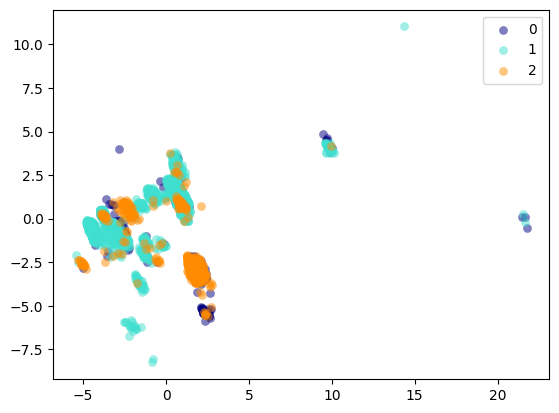

In [285]:
std_p1 = StandardScaler()
X_train_p1 = std_p1.fit_transform(X_train)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_p1)
target_names = ['0','1','2']

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], color=color, alpha=.5, lw=0.2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

### After SMOTETomek (RandomForest adjustments)

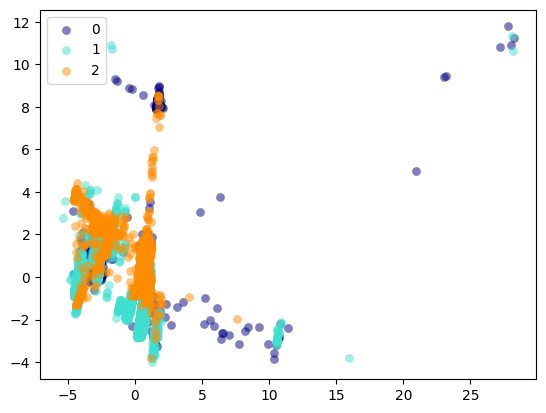

In [286]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_rf)
target_names = ['0','1','2']

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_pca[y_train_rf== i, 0], X_pca[y_train_rf == i, 1], color=color, alpha=.5, lw=0.2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

(It might be better to use UMAP over PCA)

# Hyperparameter Tuning

In [53]:
def clf_stats(search, res, X_valid):
    mean_cols = []
    for col in res.columns:
        if ('test' in col) & ('split' in col):
            mean_cols.append(col)

    pred = search.predict(X_valid)
    print('valid F1 macro: ', f1_score(y_valid,pred, average='macro'))
    print('valid deceased: ', f1_score(y_valid,pred, average=None)[0])
    check = pd.DataFrame({'pred': pred, 'actual': y_valid})
    check['correct'] = check['pred'] == check['actual']
    print('valid accuracy: ', len(check[check['correct'] == True])/len(pred))
    print('Mean F1 macro: ', res.iloc[search.best_index_]['mean_test_F1_macro'])
    print('Mean F1 deceased: ', res.iloc[search.best_index_]['mean_test_F1_deceased'])
    print('Mean F1 accuracy: ', res.iloc[search.best_index_]['mean_test_Accuracy'])
    print('minmin: ', pd.DataFrame(search.cv_results_)[mean_cols].min().min())
    print(search.best_params_)
    incorrect = check[check['correct'] == False]
    total = len(incorrect)
    n_0 = len(incorrect[(incorrect['actual'] == 0) | (incorrect['pred'] == 0)]) 
    p0w1 = len(incorrect[(incorrect['actual'] == 1) & (incorrect['pred'] == 0)])
    p0w2 = len(incorrect[(incorrect['actual'] == 2) & (incorrect['pred'] == 0)])
    p1w0 = len(incorrect[(incorrect['actual'] == 0) & (incorrect['pred'] == 1)])
    p1w2 = len(incorrect[(incorrect['actual'] == 2) & (incorrect['pred'] == 1)])
    p2w0 = len(incorrect[(incorrect['actual'] == 0) & (incorrect['pred'] == 2)])
    p2w1 = len(incorrect[(incorrect['actual'] == 1) & (incorrect['pred'] == 2)])
    print(f'total incorrect: {total}/{len(X_valid)}')
    print('predicted 0, was 1:', p0w1)
    print('predicted 0, was 2:', p0w2)
    print('predicted 1, was 0:', p1w0)
    print('predicted 1, was 2:', p1w2)
    print('predicted 2, was 0:', p2w0)
    print('predicted 2, was 1:', p2w1)
    # print(f'total 2-0 confusions: {p0w2+p2w0}/{total}')
    # print(f'total 1-0 confusions: {p0w1+p1w0}/{total}')
    # print(f'total 2-1 confusions: {p1w2+p2w1}/{total}')
    print(f'number of errors involving 0: {n_0}/{total}')

### KNeighbors

In [120]:
kn = KNeighborsClassifier()
params = {
    'n_neighbors': np.arange(100,150,1),
    'weights': ['uniform','distance'],
    'algorithm': ['ball_tree','kd_tree','brute'],
    'leaf_size': np.arange(10,50,1),
    'p': [1,2],
    'metric': ['cityblock','euclidean','l1','l2','manhattan']
}
kn_search = RandomizedSearchCV(kn,
                               params,
                               cv=k_fold,
                               scoring=scoring,
                               refit='F1_deceased',
                               n_iter=40,
                               n_jobs=-1,
                               error_score='raise').fit(X_train_kn,y_train_kn)

kn_res = pd.DataFrame(kn_search.cv_results_)
kn_res['classifier'] = 'KNeighbors'
clf_stats(kn_search, kn_res, X_valid_kn)

valid F1 macro:  0.7756514272636829
valid deceased:  0.47411444141689374
valid accuracy:  0.9396853146853147
Mean F1 macro:  0.8435106694541623
Mean F1 deceased:  0.6807200695461517
Mean F1 accuracy:  0.8839815283711353
minmin:  0.5983313468414779
{'weights': 'distance', 'p': 2, 'n_neighbors': 104, 'metric': 'l1', 'leaf_size': 40, 'algorithm': 'brute'}
total incorrect: 207/3432
predicted 0, was 1: 15
predicted 0, was 2: 69
predicted 1, was 0: 31
predicted 1, was 2: 11
predicted 2, was 0: 78
predicted 2, was 1: 3
number of errors involving 0: 193/207


### RandomForest

In [126]:
distr = Counter(y_train_rf)
w0 = len(y_train_rf)/(distr[0]*3)
w1 = len(y_train_rf)/(distr[1]*3)
w2 = len(y_train_rf)/(distr[2]*3)
s0 = 0.08
s1 = 0.12
s2 = 0.12
class_weights_dict = {0: s0*w0, 1: s1*w1, 2: s2*w2}
class_weights = class_weight.compute_sample_weight(class_weight=class_weights_dict, y=y_train_rf)

rf = RandomForestClassifier(criterion='entropy', n_estimators=150)
params = {
    'max_depth': [9,10,11,12,13],
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': np.arange(10,201,20),
    'min_samples_split': np.arange(10,201,20)
}
rf_search = RandomizedSearchCV(rf,
                                params,
                                cv=k_fold,
                                scoring=scoring,
                                refit='F1_macro',
                                n_jobs=None,
                                n_iter=30
                                ).fit(X_train_rf,y_train_rf,sample_weight=class_weights)
rf_res = pd.DataFrame(rf_search.cv_results_)
rf_res['classifier'] = 'RandomForest'
clf_stats(rf_search, rf_res, X_valid_rf)

valid F1 macro:  0.8042515303881764
valid deceased:  0.5493333333333333
valid accuracy:  0.9455128205128205
Mean F1 macro:  0.8280596824259042
Mean F1 deceased:  0.5890125748083467
Mean F1 accuracy:  0.9139470983573984
minmin:  0.45977011494252873
{'min_samples_split': 110, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 12}
total incorrect: 187/3432
predicted 0, was 1: 8
predicted 0, was 2: 68
predicted 1, was 0: 31
predicted 1, was 2: 10
predicted 2, was 0: 62
predicted 2, was 1: 8
number of errors involving 0: 169/187


### Compile CV Results

In [284]:
param_columns = rf_res.filter(like='param_')  # Select columns starting with 'param_'
rf_res['params'] = param_columns.apply(lambda row: ', '.join(f"{param[6:]}={value}" for param, value in row.dropna().items()), axis=1)

param_columns = kn_res.filter(like='param_')  # Select columns starting with 'param_'
kn_res['params'] = param_columns.apply(lambda row: ', '.join(f"{param[6:]}={value}" for param, value in row.dropna().items()), axis=1)

rf_res.to_csv('results/randomforest_tuning.txt',index=False)
kn_res.to_csv('results/knn_tuning.txt',index=False)

cols_res = ['classifier','params','mean_test_F1_macro','mean_test_F1_deceased','mean_test_F1_hospitalized','mean_test_F1_nonhospitalized','mean_test_Accuracy']
rf_data = rf_res[cols_res].iloc[[rf_search.best_index_]]
kn_data = kn_res[cols_res].iloc[[kn_search.best_index_]]
all_res = pd.concat([rf_data, kn_data])
all_res

,classifier,params,mean_test_F1_macro,mean_test_F1_deceased,mean_test_F1_hospitalized,mean_test_F1_nonhospitalized,mean_test_Accuracy
14,RandomForest,"min_samples_split=110, min_samples_leaf=10, ma...",0.828060,0.589013,0.978149,0.917017,0.913947
6,KNeighbors,"weights=distance, p=2, n_neighbors=104, metric...",0.843511,0.680720,0.950829,0.898982,0.883982


# Overfitting

### KNeigbors

Note: KNN does not 'overfit' the same way a DecisionTree might. Its parameter _n_neighbors_ dictates how sensitive it is to local objects, so it can be considered a way to tune bias.

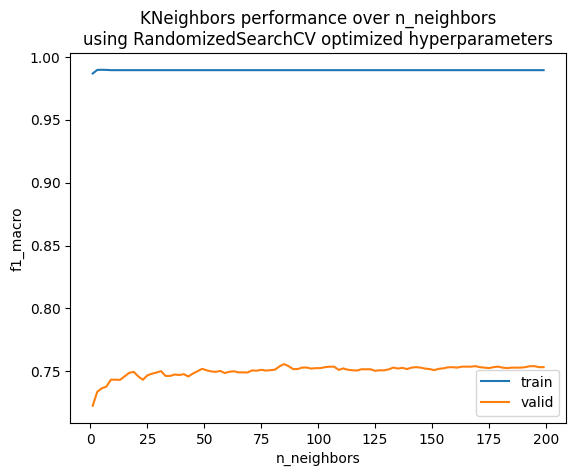

best max_depth for validation: 85
best validation F1 macro: 0.7558192913552092
valid F1 deceased:  0.44
valid accuracy: 0.9224941724941725


In [208]:
nn = np.arange(1,201,2)
perf_train = []
perf_valid = []

highest_valid = 0
best_pred = None
best_nn = 1
for i in nn:
    params = kn_search.best_params_
    params['n_neighbors'] = i
    kn_of = KNeighborsClassifier(**params, n_jobs=-1)
    kn_of.fit(X_train_res,y_train_res)
    pred_train = kn_of.predict(X_train_kn)
    pred_valid = kn_of.predict(X_valid_kn)
    f1_train = f1_score(y_train_kn,pred_train,average='macro')
    f1_valid = f1_score(y_valid,pred_valid,average='macro')
    perf_train.append(f1_train)
    perf_valid.append(f1_valid)
    if f1_valid > highest_valid:
        best_pred = pred_valid
        highest_valid = f1_valid
        best_nn = i
perf_train_np = np.array(perf_train)
perf_valid_np = np.array(perf_valid)
plt.xlabel('n_neighbors')
plt.ylabel('f1_macro')
plt.title('KNeighbors performance over n_neighbors\nusing RandomizedSearchCV optimized hyperparameters')
plt.legend([perf_train, perf_valid], ['train', 'valid'])
plt.plot(nn, perf_train)
plt.plot(nn, perf_valid)
plt.legend(['train','valid'])
plt.savefig('plots/knn_overfitting.png')
plt.show()

print('best max_depth for validation:',best_nn)
print('best validation F1 macro:', highest_valid)
print('valid F1 deceased: ',f1_deceased_func(y_valid, best_pred))
print('valid accuracy:', accuracy_score(y_valid, best_pred))

### RandomForest

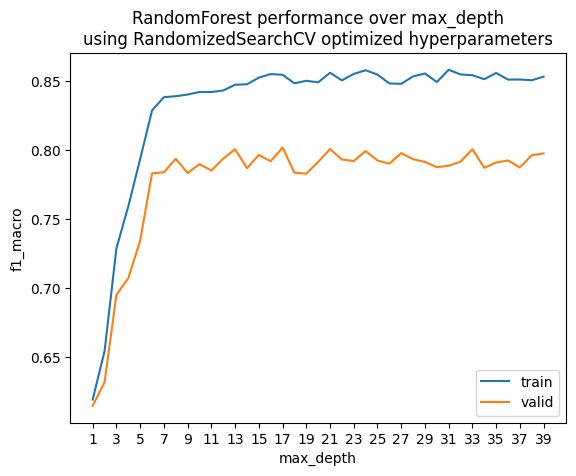

best max_depth for validation: 17
best validation F1 macro: 0.8018799209794153
valid F1 deceased:  0.5253164556962026
valid accuracy: 0.9501748251748252


In [209]:
max_depth = np.arange(1,40,1)
perf_train = []
perf_valid = []

distr = Counter(y_train_rf)
w0 = len(y_train_rf)/(distr[0]*3)
w1 = len(y_train_rf)/(distr[1]*3)
w2 = len(y_train_rf)/(distr[2]*3)
s0 = 0.06
s1 = 0.12
s2 = 0.12
class_weights_dict = {0: s0*w0, 1: s1*w1, 2: s2*w2}
class_weights = class_weight.compute_sample_weight(class_weight=class_weights_dict, y=y_train_rf)

highest_valid = 0
best_pred = None
best_md = 1
for i in max_depth:
    params = rf_search.best_params_
    params['max_depth'] = i
    rf_of = RandomForestClassifier(**params, criterion='entropy', n_estimators=100)
    rf_of.fit(X_train_rf,y_train_rf,sample_weight=class_weights)
    pred_train = rf_of.predict(X_train_rf)
    pred_valid = rf_of.predict(X_valid_rf)
    f1_train = f1_score(y_train_rf,pred_train,average='macro')
    f1_valid = f1_score(y_valid,pred_valid,average='macro')
    perf_train.append(f1_train)
    perf_valid.append(f1_valid)
    if f1_valid > highest_valid:
        best_pred = pred_valid
        highest_valid = f1_valid
        best_md = i
perf_train_np = np.array(perf_train)
perf_valid_np = np.array(perf_valid)

plt.xlabel('max_depth')
plt.ylabel('f1_macro')
plt.legend(['train','valid'])
plt.title('RandomForest performance over max_depth\nusing RandomizedSearchCV optimized hyperparameters')
plt.xticks(np.arange(1,40,2))

plt.plot(max_depth, perf_train)
plt.plot(max_depth, perf_valid)
plt.legend(['train','valid'])
plt.savefig('plots/rf_overfitting.png')
plt.show()

print('best max_depth for validation:',best_md)
print('best validation F1 macro:', highest_valid)
print('valid F1 deceased: ',f1_deceased_func(y_valid, best_pred))
print('valid accuracy:', accuracy_score(y_valid, best_pred))


# Final Predictions and KFold output
Using RandomForest to predict

In [279]:
import csv

rf_final = rf_search.best_estimator_
unlabelled_scaled = std_rf.transform(unlabelled[rf_cols])
preds = rf_final.predict(unlabelled_scaled)

with open('submission_randomforest.csv', "w") as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction"])
    for i, pred in enumerate(preds):
        wr.writerow([str(i), str(pred)])